
# Missouri VA Access Analytics — Exploratory Data Analysis (EDA)

This notebook performs exploratory data analysis (EDA) on the **Missouri subset** of the Griffith (2024) dataset:  
*Appointment Wait Times for Primary and Specialty Care in Veterans Health Administration Facilities vs. Community Medical Centers*.

**Repository paths assumed:**  
- Cleaned data: `data/cleaned/cleaned_mo_waits.csv.gz`  
- Figures output: `figures/eda/`  
- Metadata/logs: `data/metadata/`

> Tip: Run this notebook from the project root so relative paths resolve correctly.


## 1) Environment Setup and Imports

In [1]:
# --- Bootstrap: force .venv site-packages when kernel is wrong ---
import sys, os
from pathlib import Path

PROJECT_ROOT = Path.cwd().resolve()
probe = PROJECT_ROOT
for _ in range(6):
    if (probe / ".venv").exists() and (probe / "data").exists():
        PROJECT_ROOT = probe
        break
    if probe.parent == probe:
        break
    probe = probe.parent

venv_site = PROJECT_ROOT / ".venv" / "Lib" / "site-packages"
print("[BOOT] sys.executable:", sys.executable)
print("[BOOT] expected venv site-packages:", venv_site)

if venv_site.exists() and str(venv_site) not in sys.path:
    if ".venv" not in sys.executable.replace("/", "\\"):
        sys.path.insert(0, str(venv_site))
        print("[BOOT] Patched sys.path with .venv site-packages.")
    else:
        print("[BOOT] Running inside .venv; no patch needed.")
else:
    print("[BOOT] Could not locate .venv site-packages; check repo structure.")

import importlib
spec = importlib.util.find_spec("numpy")
print("[BOOT] numpy spec:", spec.origin if spec else "NOT FOUND")

# --- Imports (CSV-only, robust) ---
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Optional libs
try:
    import seaborn as sns
    sns.set_theme(context="notebook", style="whitegrid")
except Exception:
    print("[WARN] seaborn not available; proceeding with matplotlib only.")

try:
    import missingno as msno
except Exception:
    print("[WARN] missingno not installed. Install with `pip install missingno` if desired.")

# --- Config ---
np.random.seed(42)
plt.rcParams.update({"figure.figsize": (9, 5),
                     "axes.titlesize": 13,
                     "axes.labelsize": 11})

# --- Project paths ---
from pathlib import Path
def find_project_root(start: Path, markers=("data", "scripts", ".git")) -> Path:
    p = start.resolve()
    for _ in range(6):
        if (p / "data").exists() or any((p / m).exists() for m in markers):
            return p
        if p.parent == p:
            break
        p = p.parent
    return start.resolve()

PROJECT_ROOT = find_project_root(Path.cwd())
DATA_CLEANED = PROJECT_ROOT / "data" / "cleaned"
FIG_DIR = PROJECT_ROOT / "figures" / "eda"
META_DIR = PROJECT_ROOT / "data" / "metadata"
FIG_DIR.mkdir(parents=True, exist_ok=True)
META_DIR.mkdir(parents=True, exist_ok=True)

CSV_FILE = DATA_CLEANED / "cleaned_mo_waits.csv.gz"

print(f"[INFO] Project root: {PROJECT_ROOT}")
print(f"[INFO] Using CSV:    {CSV_FILE}")
print(f"[INFO] Figures ->    {FIG_DIR}")

# --- Load data ---
if not CSV_FILE.exists():
    raise FileNotFoundError(
        f"CSV not found at:\n  - {CSV_FILE}\n"
        "Run the cleaning script first:\n"
        "  .venv\\Scripts\\Activate\n"
        "  python scripts\\clean_mo_waits.py"
    )

df = pd.read_csv(CSV_FILE, compression="infer", low_memory=False)

print(f"[INFO] Python exe:   {sys.executable}")
print(f"[INFO] pandas:       {pd.__version__}")
print(f"[INFO] numpy:        {np.__version__}")
print(f"[INFO] Shape:        {df.shape}")
print(f"[INFO] Columns:      {list(df.columns)}")

[BOOT] sys.executable: c:\Projects\missouri-va-access-analytics\.venv\Scripts\python.exe
[BOOT] expected venv site-packages: C:\Projects\missouri-va-access-analytics\.venv\Lib\site-packages
[BOOT] Running inside .venv; no patch needed.
[BOOT] numpy spec: c:\Projects\missouri-va-access-analytics\.venv\Lib\site-packages\numpy\__init__.py
[INFO] Project root: C:\Projects\missouri-va-access-analytics
[INFO] Using CSV:    C:\Projects\missouri-va-access-analytics\data\cleaned\cleaned_mo_waits.csv.gz
[INFO] Figures ->    C:\Projects\missouri-va-access-analytics\figures\eda
[INFO] Python exe:   c:\Projects\missouri-va-access-analytics\.venv\Scripts\python.exe
[INFO] pandas:       2.3.3
[INFO] numpy:        2.3.4
[INFO] Shape:        (1187582, 21)
[INFO] Columns:      ['patientsid', 'activitydatetime', 'year', 'month', 'sta3n', 'stopcode', 'dta', 'dts', 'dtc', 'dtot', 'non_va', 'zip', 'state', 'disp', 'AdministrativeFlag', '__year', 'care_setting', 'veteran_zip3', 'wait_days', 'specialty_catego

## 2) Data Loading and Basic Inspection

In [2]:
# --- Load cleaned CSV ---
DATA_FILE = CSV_FILE  # ensure the variable exists

assert DATA_FILE.exists(), f"Cleaned data not found at {DATA_FILE}. Run the cleaning script first."

df = pd.read_csv(
    DATA_FILE,
    low_memory=False,
    parse_dates=["activitydatetime"],  # remove if column not present
    dtype_backend="numpy_nullable"
)

print("[INFO] Shape:", df.shape)
print("[INFO] Columns:", list(df.columns))

# Show preview
display(df.head(3))
display(df.tail(3))

# --- Basic info & summary ---
import io
buf = io.StringIO()
df.info(buf=buf)
print(buf.getvalue())

# Compatibility-safe describe
try:
    summary = df.describe(include="all", datetime_is_numeric=True)
except TypeError:
    # older pandas fallback
    summary = df.describe(include="all")

display(summary.T)

[INFO] Shape: (1187582, 21)
[INFO] Columns: ['patientsid', 'activitydatetime', 'year', 'month', 'sta3n', 'stopcode', 'dta', 'dts', 'dtc', 'dtot', 'non_va', 'zip', 'state', 'disp', 'AdministrativeFlag', '__year', 'care_setting', 'veteran_zip3', 'wait_days', 'specialty_category', 'met_access_standard']


,patientsid,activitydatetime,year,month,sta3n,stopcode,dta,dts,dtc,dtot,...,zip,state,disp,AdministrativeFlag,__year,care_setting,veteran_zip3,wait_days,specialty_category,met_access_standard
0,18774859,2015-08-14 10:46:40+00:00,2015,8,657,197,1970-01-01 00:00:00.000000006+00:00,1970-01-01 00:00:00.000000002+00:00,1970-01-01 00:00:00.000000003+00:00,9.0,...,631,MISSOURI,COMPLETE/UPDATE,<NA>,2015,VA,6,9.0,unknown,1
1,18774859,2016-11-18 13:05:35+00:00,2016,11,657,408,1970-01-01 00:00:00+00:00,1970-01-01 00:00:00.000000003+00:00,1970-01-01 00:00:00.000000009+00:00,9.0,...,631,MISSOURI,COMPLETE/UPDATE,Y,2016,Community,6,9.0,unknown,1
2,18774863,2019-09-16 12:17:51+00:00,2019,9,657,104,1970-01-01 00:00:00+00:00,1970-01-01 00:00:00.000000001+00:00,1970-01-01 00:00:00.000000004+00:00,4.0,...,637,MISSOURI,COMPLETE/UPDATE,<NA>,2019,VA,6,4.0,unknown,1


,patientsid,activitydatetime,year,month,sta3n,stopcode,dta,dts,dtc,dtot,...,zip,state,disp,AdministrativeFlag,__year,care_setting,veteran_zip3,wait_days,specialty_category,met_access_standard
1187579,1005103202,2017-09-27 14:36:45+00:00,2017,9,657,401,1970-01-01 00:00:00.000000009+00:00,1970-01-01 00:00:00.000000035+00:00,1970-01-01 00:00:00.000000025+00:00,34.0,...,636,MISSOURI,COMPLETE/UPDATE,Y,2017,Community,6,34.0,unknown,0
1187580,1005103202,2021-06-24 10:59:05+00:00,2021,6,657,409,1970-01-01 00:00:00.000000006+00:00,1970-01-01 00:00:00.000000016+00:00,1970-01-01 00:00:00.000000017+00:00,23.0,...,636,MISSOURI,COMPLETE/UPDATE,Y,2021,Community,6,23.0,unknown,1
1187581,1005103202,2017-12-18 14:16:00+00:00,2017,12,657,420,1970-01-01 00:00:00.000000002+00:00,1970-01-01 00:00:00.000000006+00:00,1970-01-01 00:00:00.000000013+00:00,15.0,...,636,MISSOURI,COMPLETE/UPDATE,Y,2017,Community,6,15.0,unknown,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1187582 entries, 0 to 1187581
Data columns (total 21 columns):
 #   Column               Non-Null Count    Dtype              
---  ------               --------------    -----              
 0   patientsid           1187582 non-null  Int64              
 1   activitydatetime     1187582 non-null  datetime64[ns, UTC]
 2   year                 1187582 non-null  Int64              
 3   month                1187582 non-null  Int64              
 4   sta3n                1187582 non-null  Int64              
 5   stopcode             1187582 non-null  Int64              
 6   dta                  1187582 non-null  string             
 7   dts                  1187582 non-null  string             
 8   dtc                  1187582 non-null  string             
 9   dtot                 1187582 non-null  Float64            
 10  non_va               1187582 non-null  Int64              
 11  zip                  1187582 non-null  Int64      

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
patientsid,1187582.0,<NA>,<NA>,<NA>,422883607.842965,5617.0,11147845.0,24762392.0,1001121492.0,1605025223.0,527716040.115779
activitydatetime,1187582,NaN,NaN,NaN,2019-10-17 15:03:09.838607616+00:00,2014-01-02 11:39:06+00:00,2017-09-14 13:51:34.500000+00:00,2019-12-07 15:27:16.500000+00:00,2022-02-03 09:11:08.249999872+00:00,2023-08-30 23:53:50+00:00,NaN
year,1187582.0,<NA>,<NA>,<NA>,2019.300224,2014.0,2017.0,2019.0,2022.0,2023.0,2.591709
month,1187582.0,<NA>,<NA>,<NA>,6.432287,1.0,4.0,6.0,9.0,12.0,3.360594
sta3n,1187582.0,<NA>,<NA>,<NA>,611.265673,358.0,589.0,589.0,657.0,757.0,39.935232
stopcode,1187582.0,<NA>,<NA>,<NA>,312.737016,102.0,204.0,312.0,408.0,907.0,132.779453
dta,1187582,305,1970-01-01 00:00:00+00:00,608171,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dts,1187582,391,1970-01-01 00:00:00+00:00,214355,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dtc,1187582,366,1970-01-01 00:00:00+00:00,53203,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dtot,1187582.0,<NA>,<NA>,<NA>,34.734269,0.0,13.0,26.0,43.0,365.0,36.244829


## 3) Data Validation and Integrity Checks

In [3]:

# Ensure key columns exist
required = [
    "activitydatetime", "year", "care_setting", "specialty_category",
    "wait_days", "met_access_standard"
]
missing = [c for c in required if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

# Logical checks
neg_waits = (df["wait_days"].fillna(pd.NA) < 0).sum()
too_long_waits = (df["wait_days"] > 365).sum()
dups = df.duplicated().sum()

print(f"[CHECK] Negative waits: {neg_waits}")
print(f"[CHECK] >365-day waits: {too_long_waits}")
print(f"[CHECK] Duplicate rows: {dups}")

# Clip extreme waits for visualization (keep original for analysis)
df["wait_days_clipped"] = df["wait_days"].clip(lower=0, upper=365)


[CHECK] Negative waits: 0
[CHECK] >365-day waits: 0
[CHECK] Duplicate rows: 0


## 4) Missing Values and Null Patterns

[INFO] Null counts by column:
 AdministrativeFlag    681509
patientsid                 0
year                       0
month                      0
sta3n                      0
activitydatetime           0
stopcode                   0
dta                        0
dtc                        0
dts                        0
non_va                     0
zip                        0
state                      0
dtot                       0
disp                       0
__year                     0
care_setting               0
veteran_zip3               0
wait_days                  0
specialty_category         0
dtype: int64


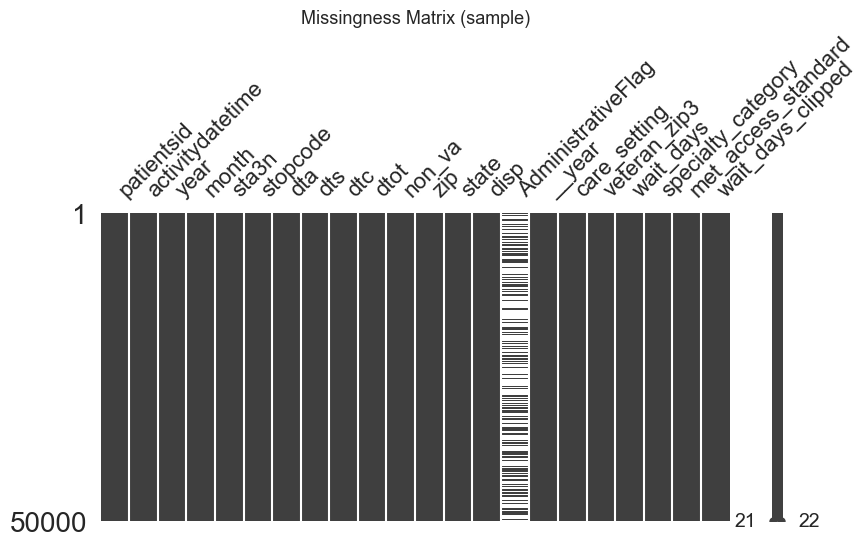

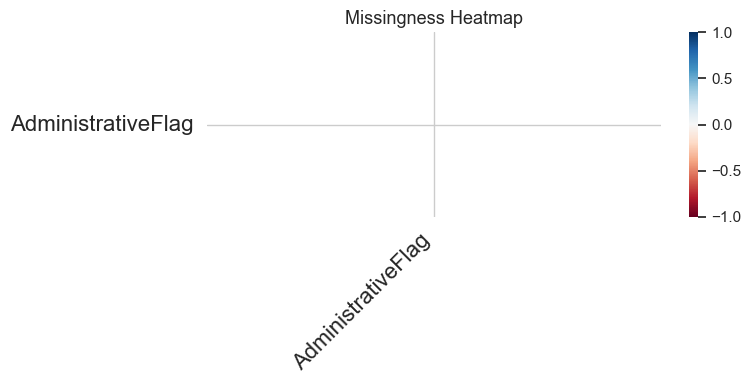

In [4]:

null_counts = df.isna().sum().sort_values(ascending=False)
print("[INFO] Null counts by column:\n", null_counts.head(20))

# Visualize if missingno is available
if 'msno' in globals():
    try:
        msno.matrix(df.sample(min(50000, len(df)), random_state=42), figsize=(9,4))
        plt.title("Missingness Matrix (sample)")
        plt.tight_layout()
        plt.savefig(FIG_DIR / "missing_matrix.png", dpi=150)
        plt.show()

        msno.heatmap(df, figsize=(8,4))
        plt.title("Missingness Heatmap")
        plt.tight_layout()
        plt.savefig(FIG_DIR / "missing_heatmap.png", dpi=150)
        plt.show()
    except Exception as e:
        print(f"[WARN] missingno visualization failed: {e}")


## 5) Descriptive Statistical Analysis

In [5]:

numeric_cols = df.select_dtypes(include=["number", "floating", "integer"]).columns.tolist()
desc = df[numeric_cols].describe(percentiles=[.05, .25, .5, .75, .95]).T
desc["skew"] = df[numeric_cols].skew(numeric_only=True)
desc["kurtosis"] = df[numeric_cols].kurtosis(numeric_only=True)
display(desc)

desc.to_csv(META_DIR / "eda_numeric_summary.csv")
print(f"[INFO] Wrote numeric summary -> {META_DIR / 'eda_numeric_summary.csv'}")


,count,mean,std,min,5%,25%,50%,75%,95%,max,skew,kurtosis
patientsid,1187582.0,422883607.842965,527716040.115779,5617.0,10687506.0,11147845.0,24762392.0,1001121492.0,1209999126.0,1605025223.0,0.67965,-1.152939
year,1187582.0,2019.300224,2.591709,2014.0,2015.0,2017.0,2019.0,2022.0,2023.0,2023.0,-0.258868,-1.04556
month,1187582.0,6.432287,3.360594,1.0,1.0,4.0,6.0,9.0,12.0,12.0,0.029714,-1.148735
sta3n,1187582.0,611.265673,39.935232,358.0,564.0,589.0,589.0,657.0,657.0,757.0,-0.08051,0.039485
stopcode,1187582.0,312.737016,132.779453,102.0,116.0,204.0,312.0,408.0,502.0,907.0,0.486449,0.380659
dtot,1187582.0,34.734269,36.244829,0.0,1.0,13.0,26.0,43.0,99.0,365.0,3.047332,14.899482
non_va,1187582.0,0.335824,0.472278,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.695251,-1.516629
zip,1187582.0,643.19018,9.536592,630.0,630.0,634.0,641.0,652.0,657.0,841.0,0.164791,-0.188254
__year,1187582.0,2019.300224,2.591709,2014.0,2015.0,2017.0,2019.0,2022.0,2023.0,2023.0,-0.258868,-1.04556
veteran_zip3,1187582.0,6.000013,0.005191,6.0,6.0,6.0,6.0,6.0,6.0,8.0,385.285771,148443.374993


[INFO] Wrote numeric summary -> C:\Projects\missouri-va-access-analytics\data\metadata\eda_numeric_summary.csv


## 6) Distribution and Outlier Visualization

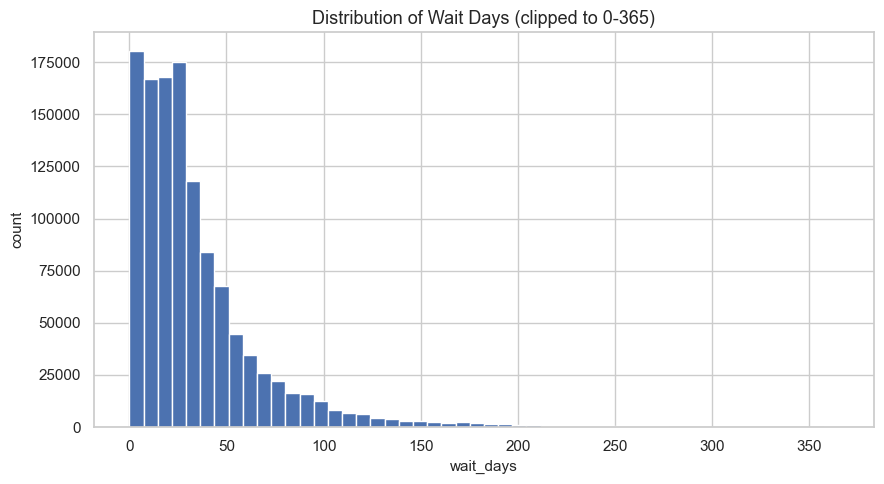

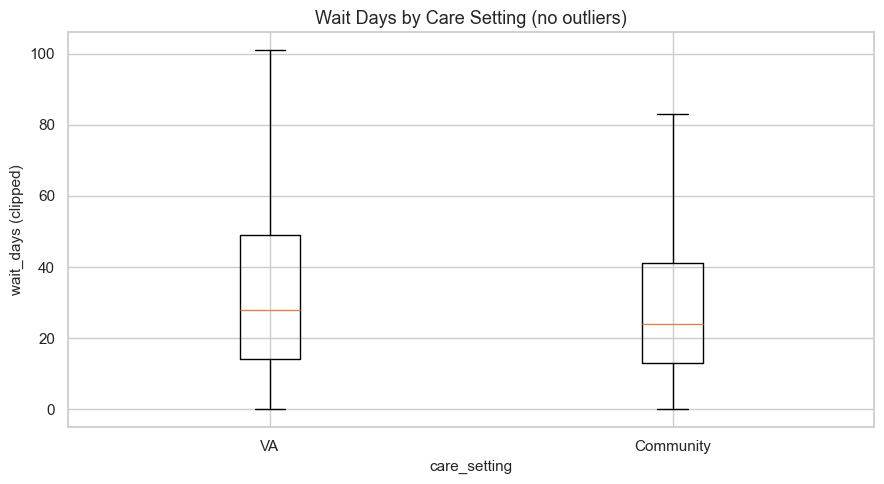

In [6]:

# Histogram / KDE for wait_days
plt.figure()
plt.hist(df["wait_days_clipped"].dropna(), bins=50)
plt.title("Distribution of Wait Days (clipped to 0-365)")
plt.xlabel("wait_days")
plt.ylabel("count")
plt.tight_layout()
plt.savefig(FIG_DIR / "wait_days_hist.png", dpi=150)
plt.show()

# Boxplot by care_setting (matplotlib implementation)
groups = [g.dropna().values for _, g in df.groupby("care_setting")["wait_days_clipped"]]
labels = df["care_setting"].dropna().unique().tolist()

plt.figure()
plt.boxplot(groups, labels=labels, showfliers=False)
plt.title("Wait Days by Care Setting (no outliers)")
plt.xlabel("care_setting")
plt.ylabel("wait_days (clipped)")
plt.tight_layout()
plt.savefig(FIG_DIR / "wait_days_by_setting_box.png", dpi=150)
plt.show()


## 7) Bivariate and Comparative Analyses

In [7]:

# Grouped stats by care_setting and specialty_category
group_stats = (
    df.groupby(["care_setting", "specialty_category"])
      ["wait_days"].agg(["count", "mean", "median", "std"])
      .sort_values(["care_setting", "mean"], ascending=[True, True])
)
display(group_stats.head(20))
group_stats.to_csv(META_DIR / "eda_group_stats_setting_specialty.csv")

# Compliance rates by setting
comp = df.pivot_table(index="care_setting", values="met_access_standard", aggfunc=["mean", "count"])
display(comp)
comp.to_csv(META_DIR / "eda_compliance_by_setting.csv")


,,count,mean,median,std
care_setting,specialty_category,,,,
Community,unknown,398819,37.618494,28.0,37.886265
VA,unknown,788763,33.275931,24.0,35.296333


,mean,count
,met_access_standard,met_access_standard
care_setting,,
Community,0.521149,398819
VA,0.582781,788763


## 8) Correlation and Feature Relationships

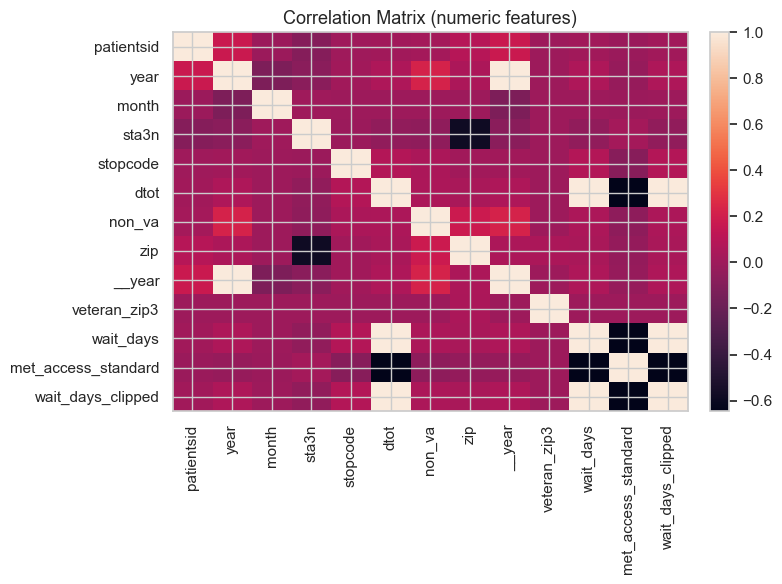

In [8]:

num_for_corr = df.select_dtypes(include=["number"]).copy()
corr = num_for_corr.corr(numeric_only=True)

plt.figure(figsize=(8,6))
im = plt.imshow(corr, aspect='auto')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Correlation Matrix (numeric features)")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.tight_layout()
plt.savefig(FIG_DIR / "correlation_matrix.png", dpi=150)
plt.show()


## 9) Temporal Trends and Policy Milestones

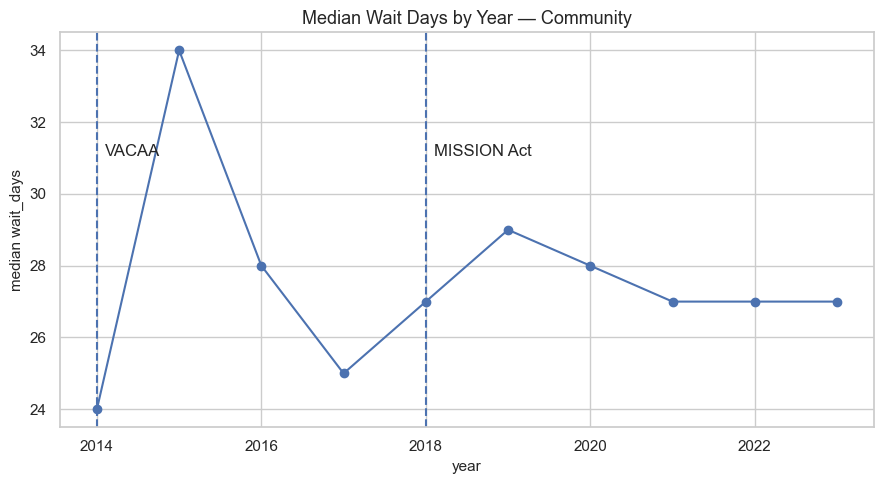

[INFO] Saved C:\Projects\missouri-va-access-analytics\figures\eda\trend_median_wait_by_year_Community.png


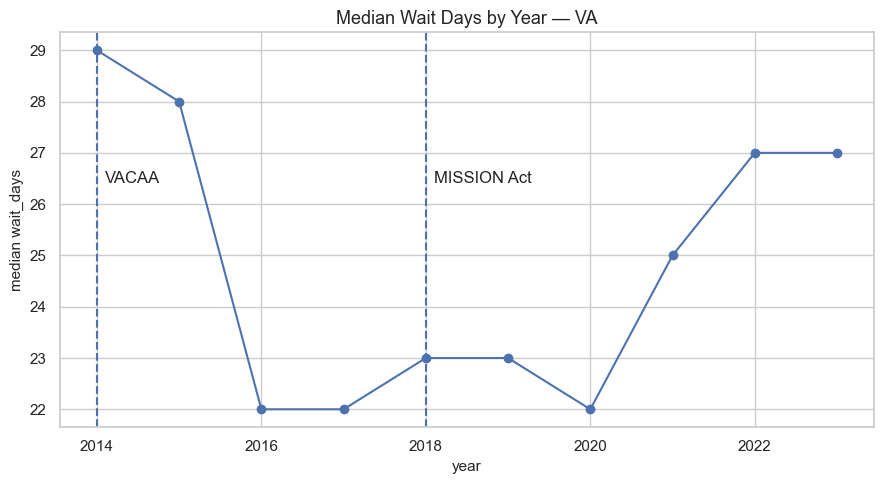

[INFO] Saved C:\Projects\missouri-va-access-analytics\figures\eda\trend_median_wait_by_year_VA.png


In [9]:

# Annual trend in wait_days by care_setting
annual = (
    df.groupby(["year", "care_setting"])
      ["wait_days"].median().reset_index()
)

for setting in annual["care_setting"].unique():
    sub = annual[annual["care_setting"] == setting]
    plt.figure()
    plt.plot(sub["year"], sub["wait_days"], marker="o")
    plt.title(f"Median Wait Days by Year — {setting}")
    plt.xlabel("year")
    plt.ylabel("median wait_days")
    # Policy markers
    for x, label in [(2014, "VACAA"), (2018, "MISSION Act")]:
        plt.axvline(x=x, linestyle="--")
        plt.text(x+0.1, plt.ylim()[1]*0.9, label)
    plt.tight_layout()
    fname = FIG_DIR / f"trend_median_wait_by_year_{setting}.png"
    plt.savefig(fname, dpi=150)
    plt.show()
    print(f"[INFO] Saved {fname}")


## 10) Summary Visualization Snapshot

In [10]:

# Save a compact set of figures already created; list them out for the report
from pprint import pprint
generated = sorted([p.name for p in FIG_DIR.glob("*.png")])
print("[INFO] Generated figures:")
pprint(generated)
(pd.Series(generated)).to_csv(META_DIR / "figures_manifest.csv", index=False)
print(f"[INFO] Wrote figures manifest -> {META_DIR / 'figures_manifest.csv'}")


[INFO] Generated figures:
['correlation_matrix.png',
 'missing_heatmap.png',
 'missing_matrix.png',
 'trend_median_wait_by_year_Community.png',
 'trend_median_wait_by_year_VA.png',
 'wait_days_by_setting_box.png',
 'wait_days_hist.png']
[INFO] Wrote figures manifest -> C:\Projects\missouri-va-access-analytics\data\metadata\figures_manifest.csv



## 11) Documentation and Version Control

- Key numeric summaries are saved under `data/metadata/`.
- Figures are saved under `figures/eda/` and can be embedded in Overleaf.
- Commit this notebook and generated artifacts to Git for traceability.
- Consider parameterizing file paths and filters for reuse.
